In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d, gaussian_kde
from numba import njit
from astropy.io import fits, ascii
import astropy.coordinates as coord
import astropy.units as u
from scipy.ndimage import gaussian_filter

from astropy.coordinates import SkyCoord, Galactic, Galactocentric
from astropy import units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/Mgdec/'

import sys
sys.path.append(basepath+'note/')

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

from lowda import load_galaxy
import lowda as lwd

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0, where=a>0), where=a>0)

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    if isinstance(ans, float):
        if a <= 0:
            ans = np.nan
    else:
        ans[a <= 0] = np.nan
    
    return ans

In [4]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [5]:
subID = 392276
snapnum = 99

In [34]:
# get trajectory of MPB
from scipy.interpolate import CubicSpline

MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)
pos = MPB['SubhaloPos']
time = meta['time'][MPB['SnapNum']]
rhalf = MPB['SubhaloHalfmassRadType'][:,4]

time = np.flip(time)
pos = np.flip(pos, axis=0)

posint = CubicSpline(time, pos)
rhalfint = CubicSpline(time, rhalf)

In [55]:
# load in subhalo
sub = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=['BirthPos', 'GFM_StellarFormationTime'])

tform = get_time(sub['GFM_StellarFormationTime'])
rhalf_attform = rhalfint(tform)
pos_attform = posint(tform)
birthpos = sub['BirthPos']

rdiff = np.linalg.norm(pos_attform - birthpos, axis=1)
in_situ = rdiff < 40

In [56]:
np.sum(in_situ)/len(in_situ)

0.9113309108492862

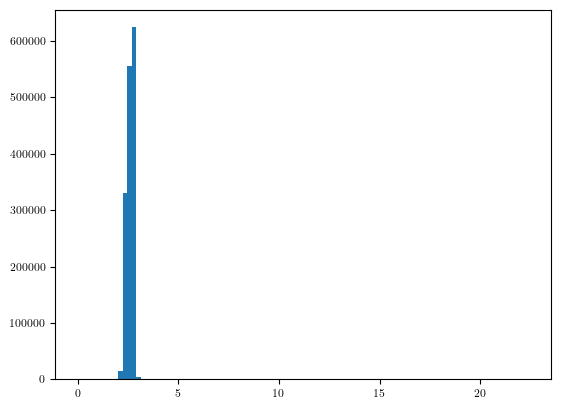

In [48]:
plt.hist(rhalf_attform, bins=100);

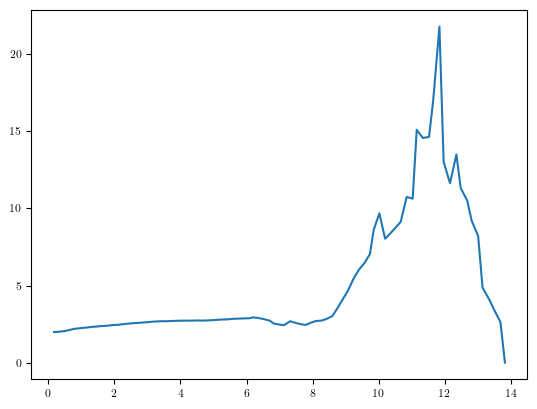

In [50]:
plt.plot(time, rhalf)